# Boosting Models

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.dates as mdates


# Covid

In [21]:
df_covid = pd.read_csv('../Data/silver/covid_data_weekly.csv')
df_covid.head()


,country,date,new_cases,cases
0,Brazil,2020-01-20,0,0
1,Brazil,2020-01-27,0,0
2,Brazil,2020-02-03,0,0
3,Brazil,2020-02-10,0,0
4,Brazil,2020-02-17,0,0


In [22]:
df_covid['date'] = pd.to_datetime(df_covid['date'])

## Pure Model

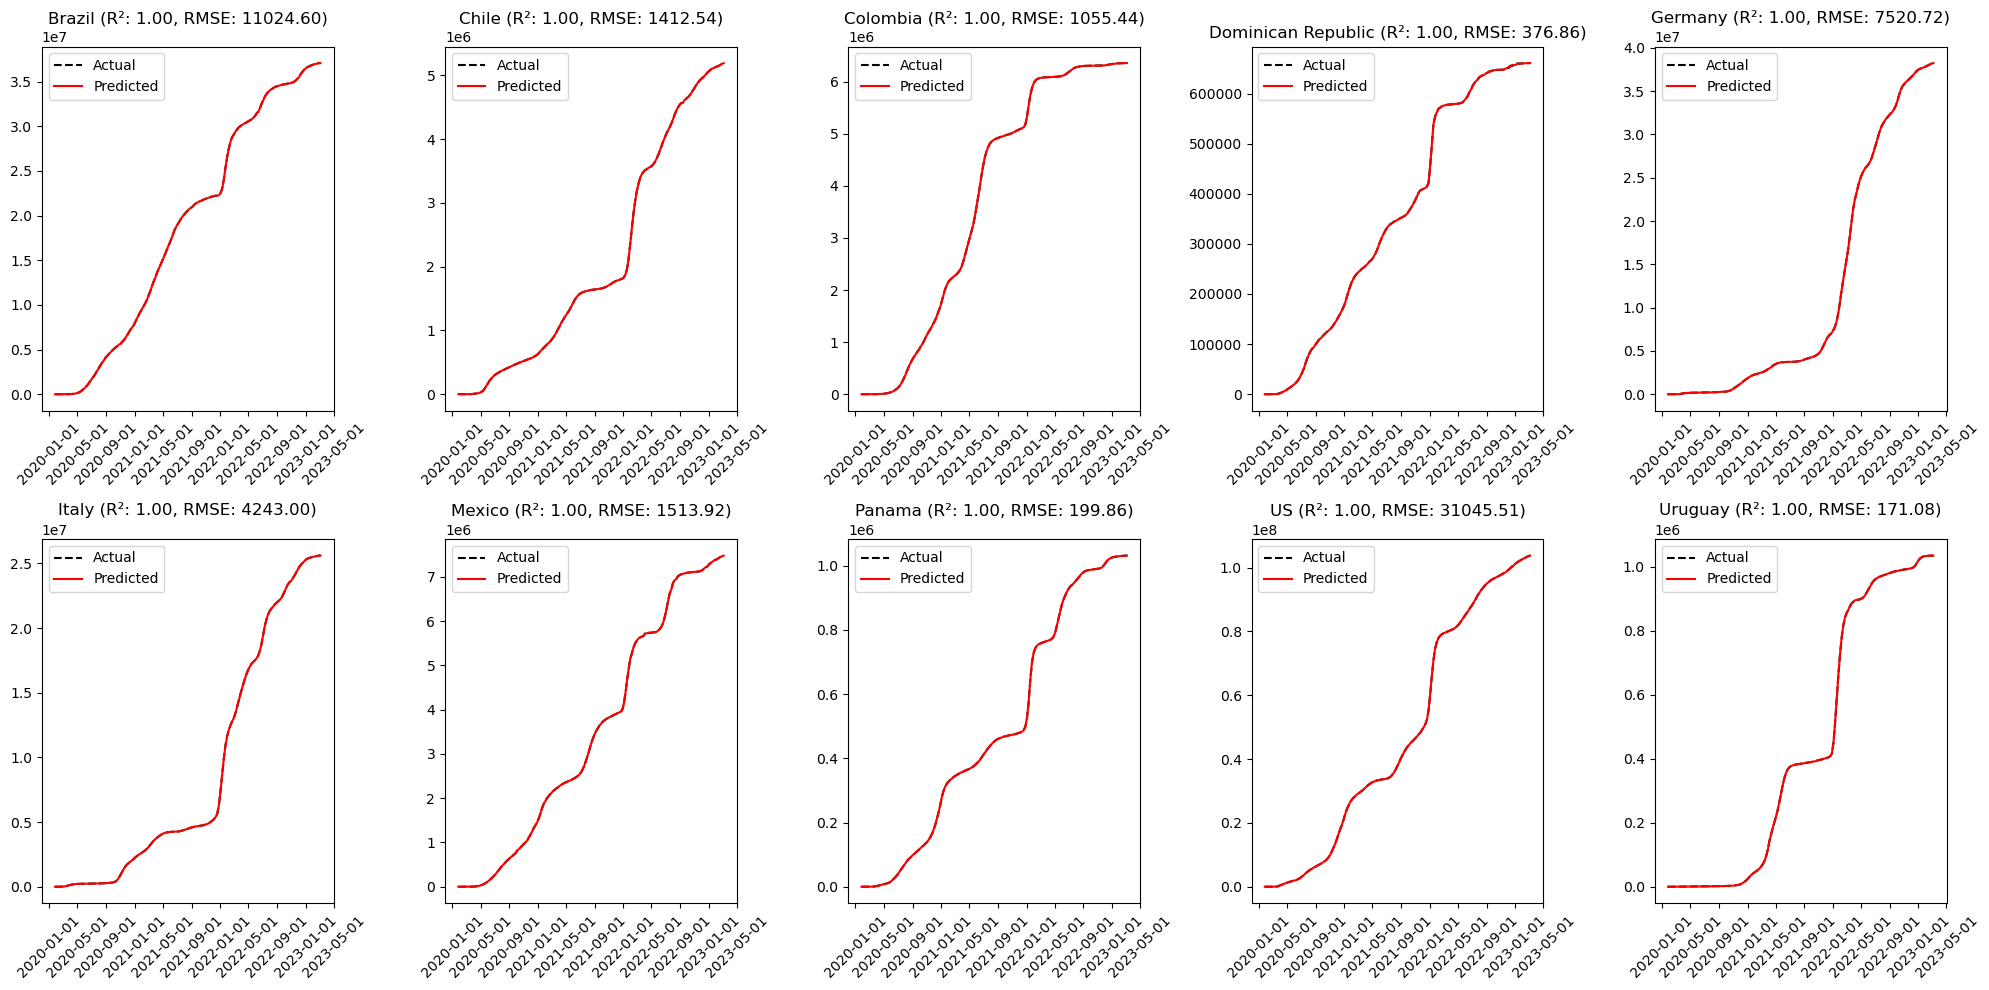

In [23]:
# Dictionary to store evaluation metrics
metrics = {}

# Get list of unique countries
countries = df_covid['country'].unique()

# Set up a 2-row x 5-column plot grid
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()  # Flatten for easy iteration

# Loop through each country
for i, country in enumerate(countries):
    if i >= 10:  # Stop at 10 plots for the grid
        break

    # Filter data for the specific country
    df_country = df_covid[df_covid['country'] == country].copy()

    # Ensure data is sorted by date
    df_country = df_country.sort_values(by='date')

    # Create a lag feature (cases with lag 1)
    df_country['cases_lag1'] = df_country['cases'].shift(1)

    # Drop NaN values created by the lag
    df_country = df_country.dropna()

    # Define target and features
    X = df_country[['cases_lag1']]
    y = df_country['cases']

    # Initialize and train XGBoost model on full data
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
    model.fit(X, y)

    # Predict on the full dataset
    y_pred = model.predict(X)

    # Compute performance metrics
    # Compute performance metrics using sklearn
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)


    # Store metrics in dictionary
    metrics[country] = {'R2': r2, 'RMSE': rmse}

    # Plot actual vs predicted values
    axes[i].plot(df_country['date'], y, label='Actual', color='black', linestyle='dashed')
    axes[i].plot(df_country['date'], y_pred, label='Predicted', color='red')
    axes[i].set_title(f"{country} (R²: {r2:.2f}, RMSE: {rmse:.2f})")
    axes[i].legend()
    # Improve date formatting
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))  # Format as YYYY-MM-DD
    axes[i].xaxis.set_major_locator(mdates.AutoDateLocator())  # Auto adjust tick frequency
    axes[i].tick_params(axis='x', rotation=45)  # Rotate dates

# Adjust layout
plt.tight_layout()
plt.show()


In [24]:
# create a metrics dataframe based on the dict metrics
df_metrics = pd.DataFrame(metrics).T
df_metrics

,R2,RMSE
Brazil,0.999999,11024.597952
Chile,0.999999,1412.535619
Colombia,1.000000,1055.438416
Dominican Republic,0.999997,376.864386
Germany,1.000000,7520.718051
Italy,1.000000,4243.000118
Mexico,1.000000,1513.916774
Panama,1.000000,199.861055
US,0.999999,31045.512912
Uruguay,1.000000,171.079825


## Train test split

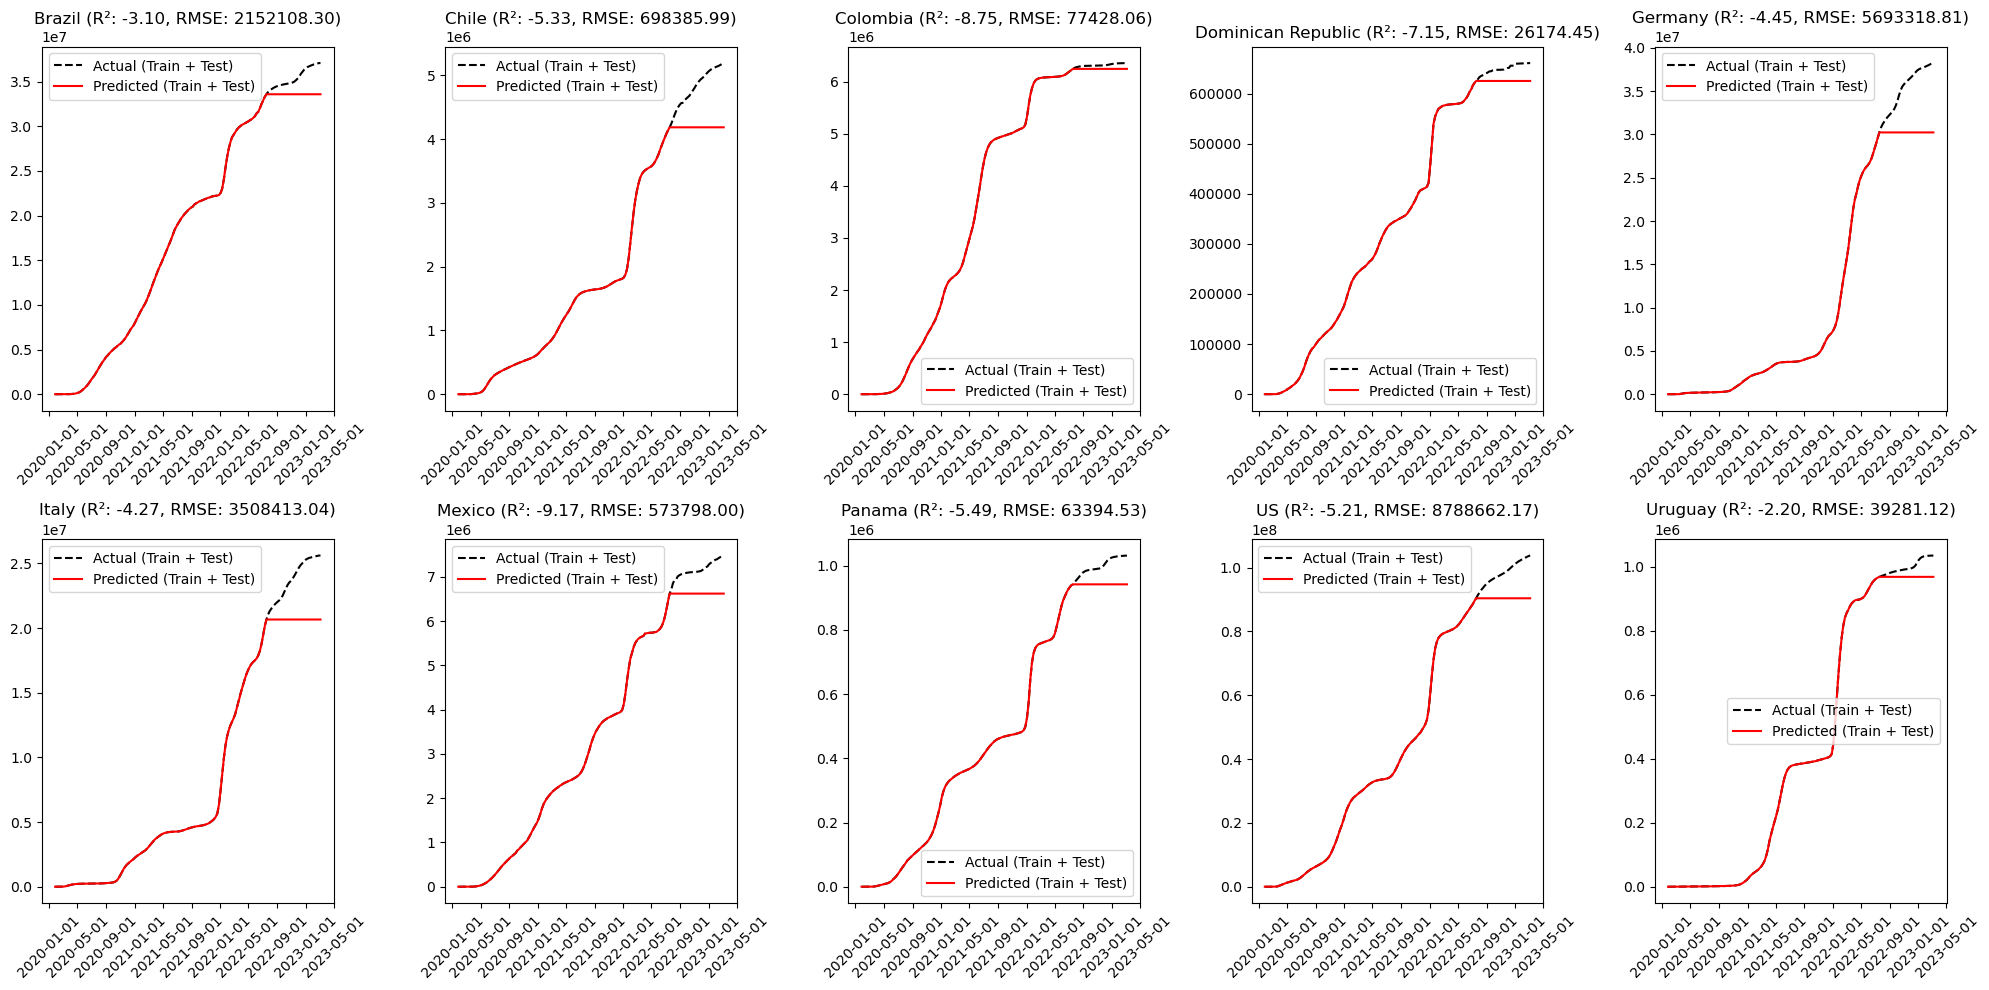

In [25]:
# Dictionary to store evaluation metrics
metrics = {}

# Get list of unique countries
countries = df_covid['country'].unique()

# Set up a 2-row x 5-column plot grid
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()  # Flatten for easy iteration

# Loop through each country
for i, country in enumerate(countries):
    if i >= 10:  # Stop at 10 plots for the grid
        break

    # Filter data for the specific country
    df_country = df_covid[df_covid['country'] == country].copy()

    # Ensure data is sorted by date
    df_country = df_country.sort_values(by='date')

    # Create a lag feature (cases with lag 1)
    df_country['cases_lag1'] = df_country['cases'].shift(1)

    # Drop NaN values created by the lag
    df_country = df_country.dropna()

    # Define target and features
    X = df_country[['cases_lag1']]
    y = df_country['cases']

    # Train-test split (80%-20%)
    split_idx = int(len(df_country) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # Initialize and train XGBoost model
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Predict on the entire dataset (train + test)
    y_pred_full = model.predict(X)

    # Extract test predictions for evaluation
    y_pred_test = y_pred_full[split_idx:]

    # Compute performance metrics (ONLY on test set)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2 = r2_score(y_test, y_pred_test)
    
    # Store metrics in dictionary
    metrics[country] = {'R2': r2, 'RMSE': rmse}

    # Plot actual vs predicted values for full dataset
    axes[i].plot(df_country['date'], y, label='Actual (Train + Test)', color='black', linestyle='dashed')
    axes[i].plot(df_country['date'], y_pred_full, label='Predicted (Train + Test)', color='red')
    axes[i].set_title(f"{country} (R²: {r2:.2f}, RMSE: {rmse:.2f})")
    axes[i].legend()
    # Improve date formatting
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))  # Format as YYYY-MM-DD
    axes[i].xaxis.set_major_locator(mdates.AutoDateLocator())  # Auto adjust tick frequency
    axes[i].tick_params(axis='x', rotation=45)  # Rotate dates

# Adjust layout
plt.tight_layout()
plt.show()



In [26]:
df_metrics = pd.DataFrame(metrics).T
df_metrics

,R2,RMSE
Brazil,-3.099632,2.152108e+06
Chile,-5.326670,6.983860e+05
Colombia,-8.746487,7.742806e+04
Dominican Republic,-7.146646,2.617445e+04
Germany,-4.449275,5.693319e+06
Italy,-4.271285,3.508413e+06
Mexico,-9.174152,5.737980e+05
Panama,-5.492049,6.339453e+04
US,-5.208042,8.788662e+06
Uruguay,-2.195776,3.928112e+04


# Date and Lag 1

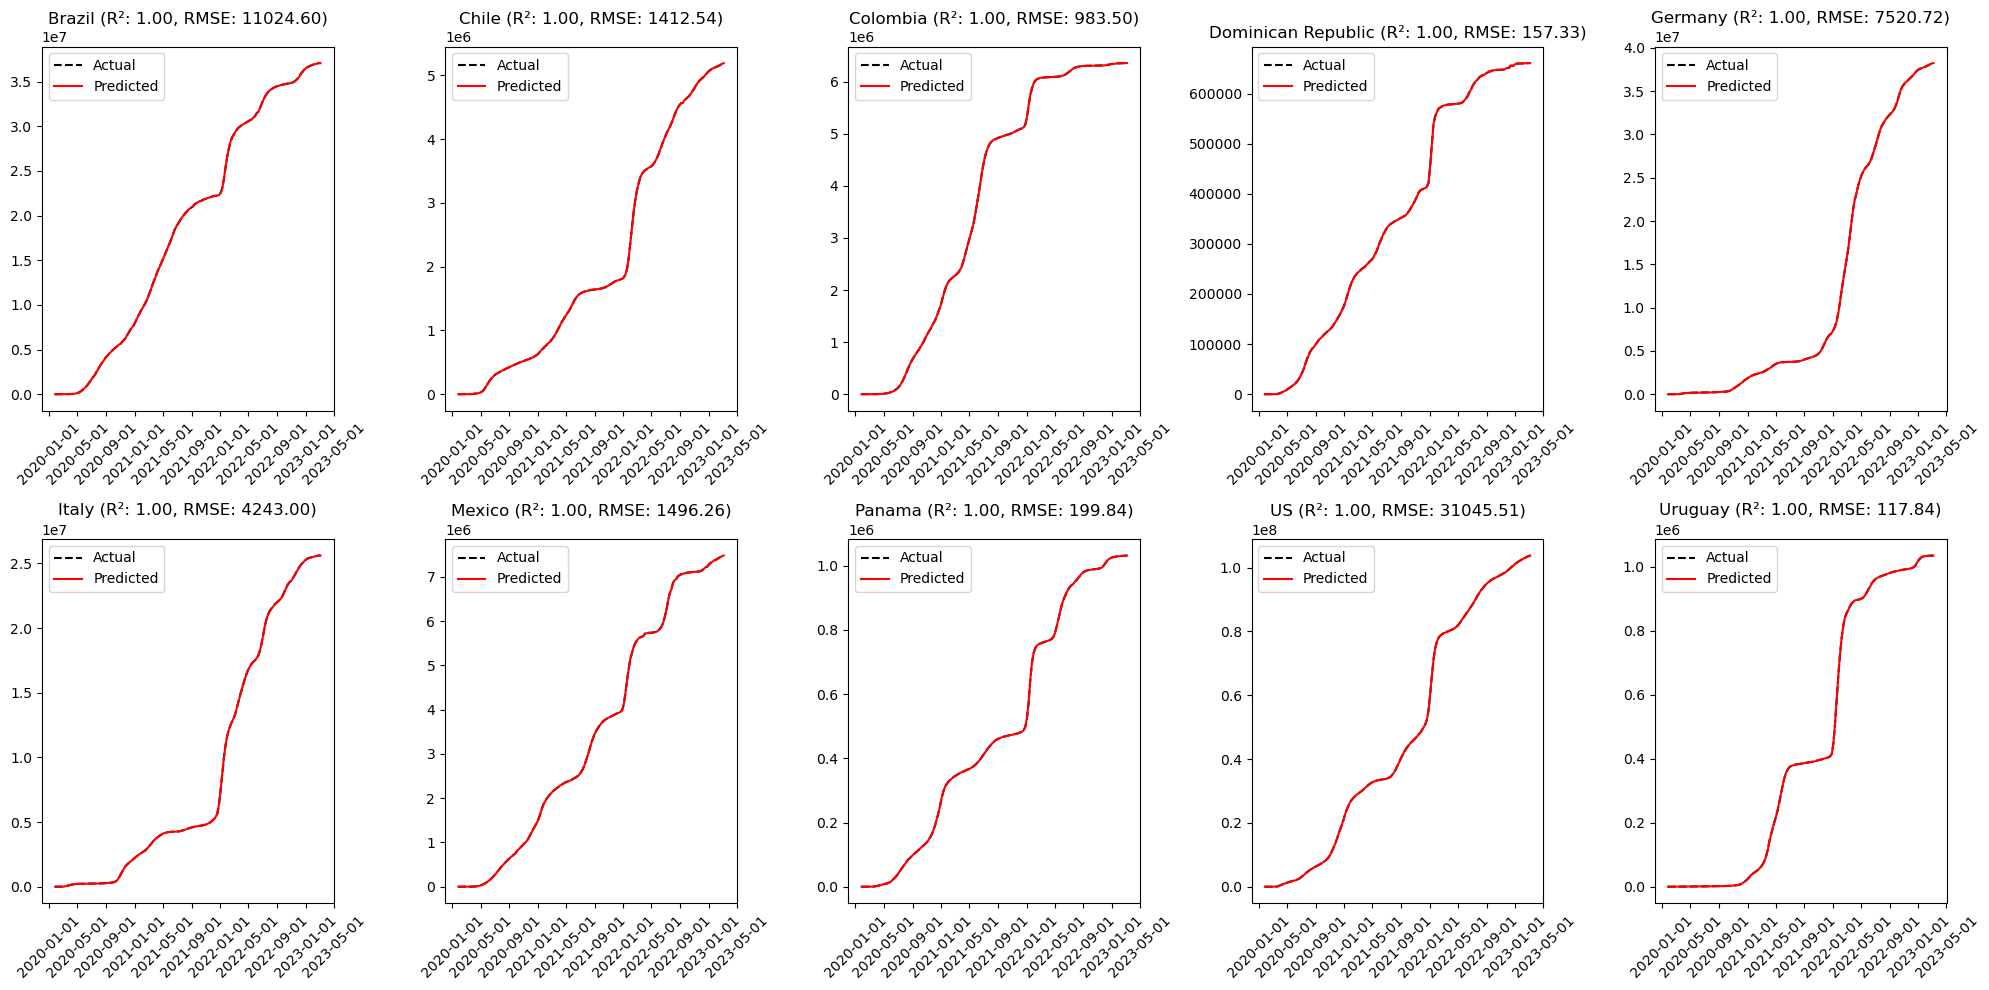

In [27]:
# Dictionary to store evaluation metrics
metrics = {}

# Get list of unique countries
countries = df_covid['country'].unique()

# Set up a 2-row x 5-column plot grid
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()  # Flatten for easy iteration

# Loop through each country
for i, country in enumerate(countries):
    if i >= 10:  # Stop at 10 plots for the grid
        break

    # Filter data for the specific country
    df_country = df_covid[df_covid['country'] == country].copy()

    # Ensure data is sorted by date
    df_country = df_country.sort_values(by='date')

    # Convert date to numeric (days since the first date)
    df_country['date_numeric'] = (df_country['date'] - df_country['date'].min()).dt.days

    # Create a lag feature (cases with lag 1)
    df_country['cases_lag1'] = df_country['cases'].shift(1)

    # Drop NaN values created by the lag
    df_country = df_country.dropna()

    # Define target and features (now includes date_numeric)
    X = df_country[['date_numeric', 'cases_lag1']]
    y = df_country['cases']

    # Initialize and train XGBoost model on full data
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
    model.fit(X, y)

    # Predict on the full dataset
    y_pred = model.predict(X)

    # Compute performance metrics using sklearn
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)

    # Store metrics in dictionary
    metrics[country] = {'R2': r2, 'RMSE': rmse}

    # Plot actual vs predicted values
    axes[i].plot(df_country['date'], y, label='Actual', color='black', linestyle='dashed')
    axes[i].plot(df_country['date'], y_pred, label='Predicted', color='red')
    axes[i].set_title(f"{country} (R²: {r2:.2f}, RMSE: {rmse:.2f})")
    axes[i].legend()
    # Improve date formatting
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))  # Format as YYYY-MM-DD
    axes[i].xaxis.set_major_locator(mdates.AutoDateLocator())  # Auto adjust tick frequency
    axes[i].tick_params(axis='x', rotation=45)  # Rotate dates

# Adjust layout
plt.tight_layout()
plt.show()


In [28]:
metrics_df = pd.DataFrame(metrics).T
metrics_df

,R2,RMSE
Brazil,0.999999,11024.597952
Chile,0.999999,1412.535619
Colombia,1.000000,983.501493
Dominican Republic,1.000000,157.331848
Germany,1.000000,7520.718051
Italy,1.000000,4243.000118
Mexico,1.000000,1496.257999
Panama,1.000000,199.839955
US,0.999999,31045.512912
Uruguay,1.000000,117.843742


## Date and Lag1: Train-Test split

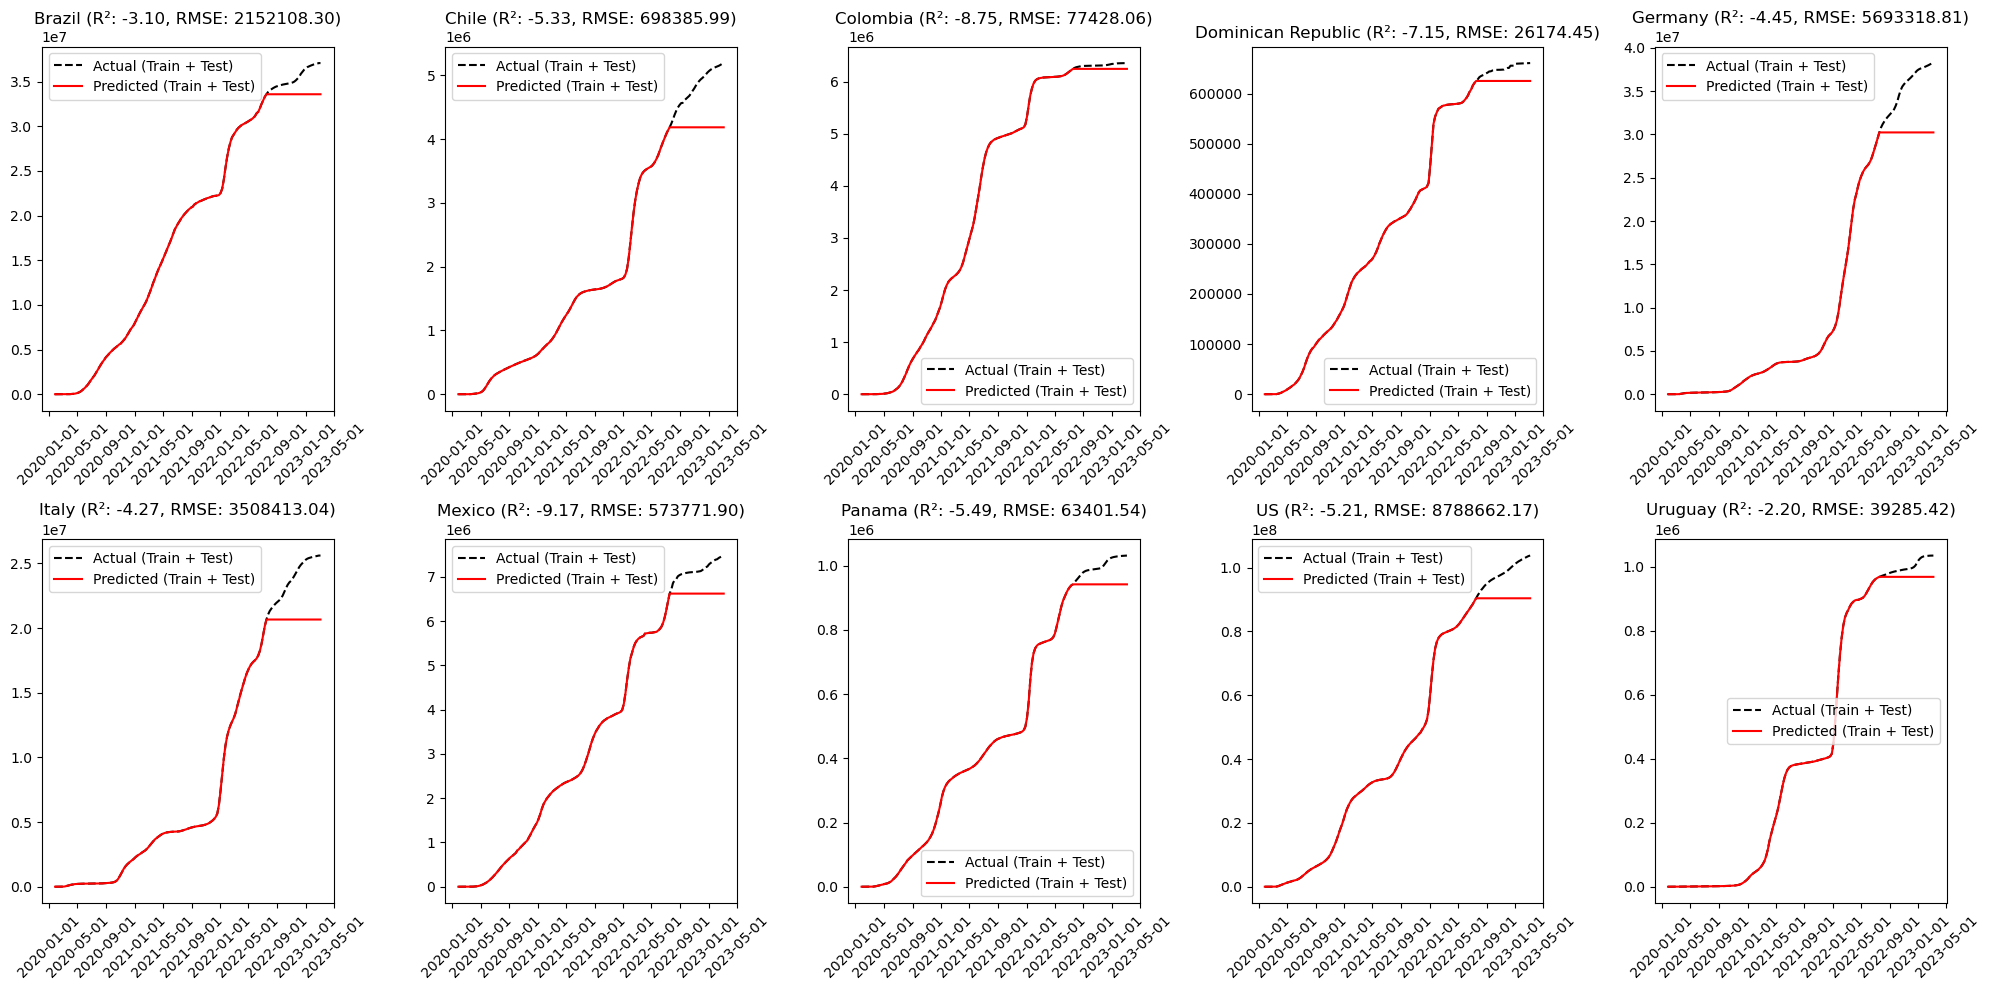

In [29]:
# Dictionary to store evaluation metrics
metrics = {}

# Get list of unique countries
countries = df_covid['country'].unique()

# Set up a 2-row x 5-column plot grid
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()  # Flatten for easy iteration

# Loop through each country
for i, country in enumerate(countries):
    if i >= 10:  # Stop at 10 plots for the grid
        break

    # Filter data for the specific country
    df_country = df_covid[df_covid['country'] == country].copy()

    # Ensure data is sorted by date
    df_country = df_country.sort_values(by='date')

    # Convert date to numeric (days since the first date)
    df_country['date_numeric'] = (df_country['date'] - df_country['date'].min()).dt.days

    # Create a lag feature (cases with lag 1)
    df_country['cases_lag1'] = df_country['cases'].shift(1)

    # Drop NaN values created by the lag
    df_country = df_country.dropna()

    # Define target and features (now includes date_numeric)
    X = df_country[['date_numeric', 'cases_lag1']]
    y = df_country['cases']

    # Train-test split (80%-20%)
    split_idx = int(len(df_country) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # Initialize and train XGBoost model
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Predict on the entire dataset (train + test)
    y_pred_full = model.predict(X)

    # Extract test predictions for evaluation
    y_pred_test = y_pred_full[split_idx:]

    # Compute performance metrics (ONLY on test set)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2 = r2_score(y_test, y_pred_test)
    
    # Store metrics in dictionary
    metrics[country] = {'R2': r2, 'RMSE': rmse}

    # Plot actual vs predicted values for full dataset
    axes[i].plot(df_country['date'], y, label='Actual (Train + Test)', color='black', linestyle='dashed')
    axes[i].plot(df_country['date'], y_pred_full, label='Predicted (Train + Test)', color='red')
    axes[i].set_title(f"{country} (R²: {r2:.2f}, RMSE: {rmse:.2f})")
    # Improve date formatting
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))  # Format as YYYY-MM-DD
    axes[i].xaxis.set_major_locator(mdates.AutoDateLocator())  # Auto adjust tick frequency
    axes[i].tick_params(axis='x', rotation=45)  # Rotate dates
    
    axes[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()


In [30]:
metrics_df = pd.DataFrame(metrics).T
metrics_df

,R2,RMSE
Brazil,-3.099632,2.152108e+06
Chile,-5.326670,6.983860e+05
Colombia,-8.746487,7.742806e+04
Dominican Republic,-7.146646,2.617445e+04
Germany,-4.449275,5.693319e+06
Italy,-4.271285,3.508413e+06
Mexico,-9.173227,5.737719e+05
Panama,-5.493486,6.340154e+04
US,-5.208042,8.788662e+06
Uruguay,-2.196476,3.928542e+04


# Epidemics

In [64]:
df_dengue = pd.read_csv('../Data/silver/dengue_no_split.csv')
df_zika = pd.read_csv('../Data/silver/zika.csv')
df_zika.drop(columns=['Unnamed: 0'], inplace=True)
df_chic = pd.read_csv('../Data/silver/chicunguya.csv')
df_chic.drop(columns=['Unnamed: 0'], inplace=True)
df_varicela = pd.read_csv('../Data/silver/varicela.csv')

In [65]:
df_dengue.head()

,SEMANA,ANO,Casos,DATE
0,1,2007,315,2007-01-01
1,2,2007,236,2007-01-08
2,3,2007,252,2007-01-15
3,4,2007,305,2007-01-22
4,5,2007,360,2007-01-29


In [66]:
df_dengue['date'] = pd.to_datetime(df_dengue['DATE'])
df_zika['date'] = pd.to_datetime(df_zika['DATE'])
df_chic['date'] = pd.to_datetime(df_chic['DATE'])
df_varicela['date'] = pd.to_datetime(df_varicela['DATE'])

In [67]:
df_dengue.head()

,SEMANA,ANO,Casos,DATE,date
0,1,2007,315,2007-01-01,2007-01-01
1,2,2007,236,2007-01-08,2007-01-08
2,3,2007,252,2007-01-15,2007-01-15
3,4,2007,305,2007-01-22,2007-01-22
4,5,2007,360,2007-01-29,2007-01-29


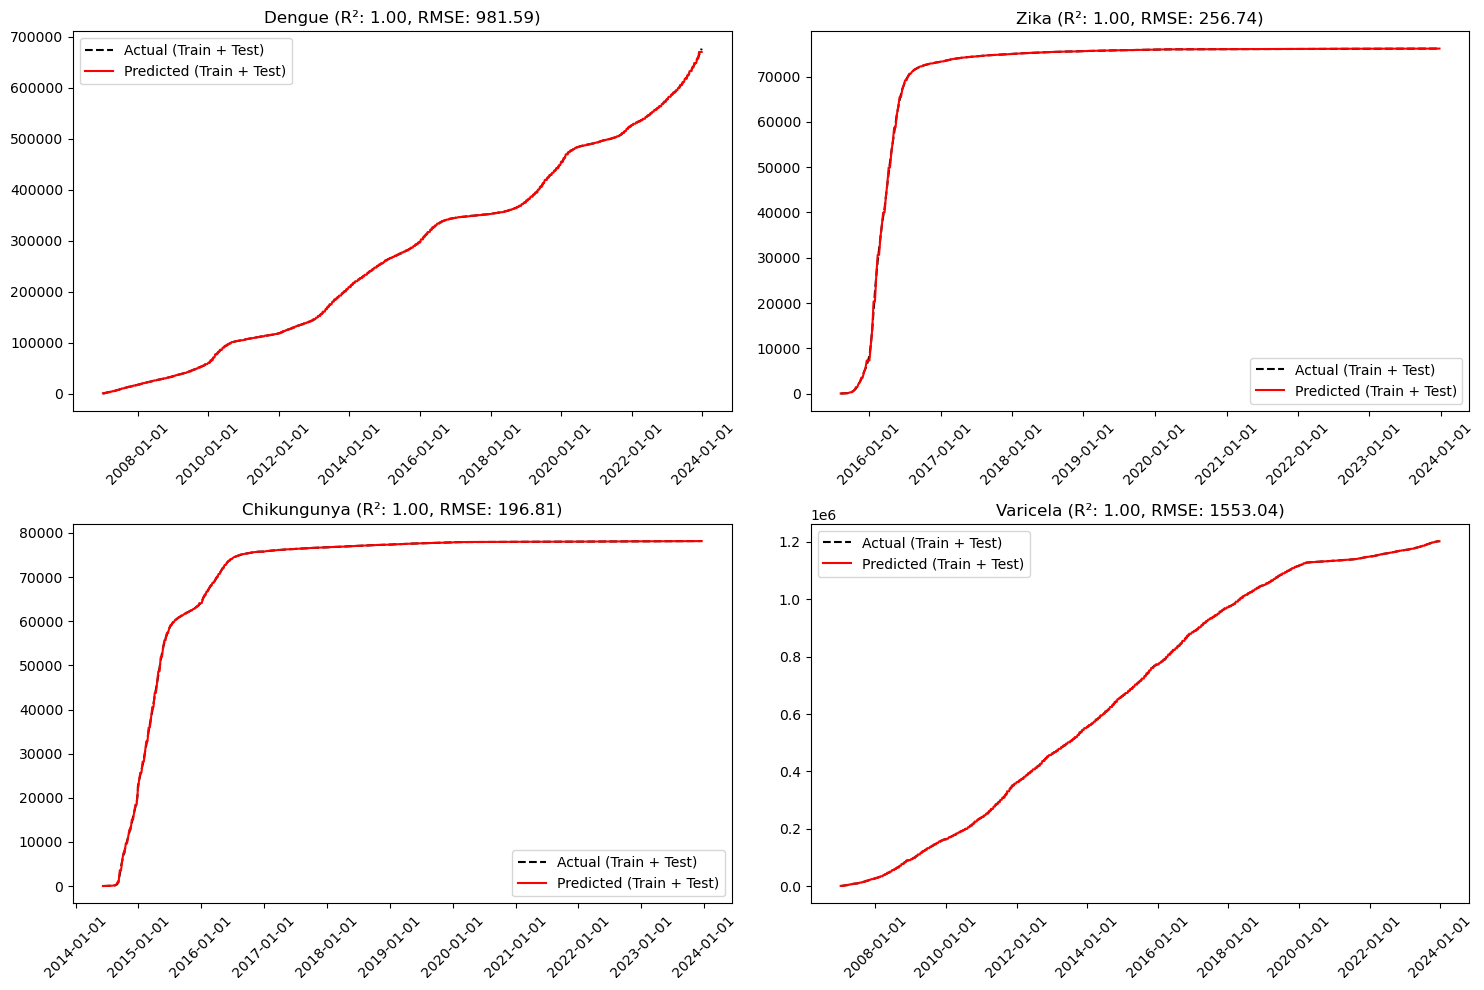

In [68]:


# Dictionary to store evaluation metrics
metrics = {}

# Define dataset dictionary
datasets = {
    "Dengue": df_dengue,
    "Zika": df_zika,
    "Chikungunya": df_chic,
    "Varicela": df_varicela
}

# Set up a 2-row x 2-column plot grid
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()  # Flatten for easy iteration

# Loop through each dataset
for i, (name, df) in enumerate(datasets.items()):
    # Ensure DATE column is in datetime format
    df['DATE'] = pd.to_datetime(df['DATE'])

    # Ensure data is sorted by date
    df = df.sort_values(by='DATE')

    # Compute cumulative cases
    df['cases'] = df['Casos'].cumsum()

    # Create a lag feature (cases with lag 1)
    df['cases_lag1'] = df['cases'].shift(1)

    # Drop NaN values created by the lag
    df = df.dropna()

    # Define target and features
    X = df[['cases_lag1']]
    y = df['cases']

    # Initialize and train XGBoost model
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
    model.fit(X, y)

    # Predict on the full dataset
    y_pred = model.predict(X)

    # Compute performance metrics
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)

    # Store metrics in dictionary
    metrics[name] = {'R2': r2, 'RMSE': rmse}

    # Plot actual vs predicted values
    axes[i].plot(df['DATE'], y, label='Actual (Train + Test)', color='black', linestyle='dashed')
    axes[i].plot(df['DATE'], y_pred, label='Predicted (Train + Test)', color='red')
    axes[i].set_title(f"{name} (R²: {r2:.2f}, RMSE: {rmse:.2f})")
    axes[i].legend()

    # Improve date formatting
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))  # Format as YYYY-MM-DD
    axes[i].xaxis.set_major_locator(mdates.AutoDateLocator())  # Auto adjust tick frequency
    axes[i].tick_params(axis='x', rotation=45)  # Rotate dates for readability

# Adjust layout
plt.tight_layout()
plt.show()


In [69]:
metrics_df = pd.DataFrame(metrics).T
metrics_df

,R2,RMSE
Dengue,0.999973,981.592679
Zika,0.999822,256.735911
Chikungunya,0.999900,196.807935
Varicela,0.999986,1553.043705


## Train-test split

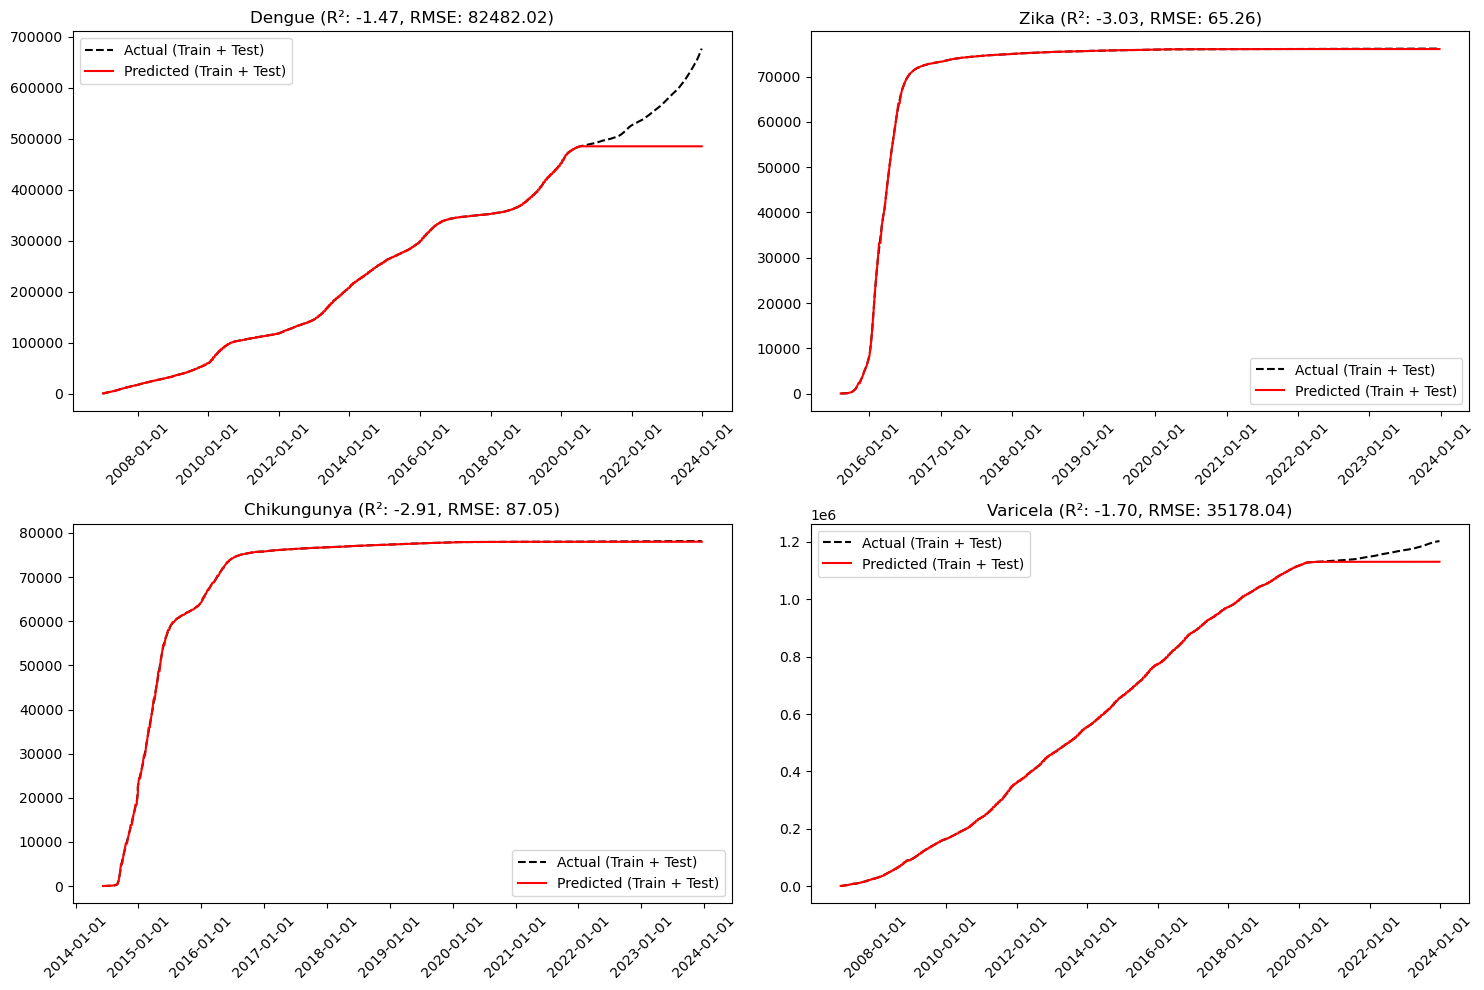

In [76]:
# Dictionary to store evaluation metrics
metrics = {}

# Define dataset dictionary
datasets = {
    "Dengue": df_dengue,
    "Zika": df_zika,
    "Chikungunya": df_chic,
    "Varicela": df_varicela
}

# Set up a 2-row x 2-column plot grid
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()  # Flatten for easy iteration

# Loop through each dataset
for i, (name, df) in enumerate(datasets.items()):
    # Ensure data is sorted by date

     # Ensure DATE column is in datetime format
    df['DATE'] = pd.to_datetime(df['DATE'])

    # Ensure data is sorted by date
    df = df.sort_values(by='DATE')

    # Compute cumulative cases
    df['cases'] = df['Casos'].cumsum()

    # Create a lag feature (cases with lag 1)
    df['cases_lag1'] = df['cases'].shift(1)

    # Drop NaN values created by the lag
    df = df.dropna()

    # Define target and features
    X = df[['cases_lag1']]
    y = df['cases']

    # Train-test split (80%-20%)
    split_idx = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # Initialize and train XGBoost model
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Predict on the full dataset (Train + Test)
    y_pred_full = model.predict(X)

    # Extract test predictions for evaluation
    y_pred_test = y_pred_full[split_idx:]

    # Compute performance metrics (ONLY on test set)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2 = r2_score(y_test, y_pred_test)

    # Store metrics in dictionary
    metrics[name] = {'R2': r2, 'RMSE': rmse}

    # Plot actual vs predicted values for full dataset
    axes[i].plot(df['DATE'], y, label='Actual (Train + Test)', color='black', linestyle='dashed')
    axes[i].plot(df['DATE'], y_pred_full, label='Predicted (Train + Test)', color='red')
    axes[i].set_title(f"{name} (R²: {r2:.2f}, RMSE: {rmse:.2f})")
    axes[i].legend()

    # Improve date formatting
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))  # Format as YYYY-MM-DD
    axes[i].xaxis.set_major_locator(mdates.AutoDateLocator())  # Auto adjust tick frequency
    axes[i].tick_params(axis='x', rotation=45)  # Rotate dates for readability

# Adjust layout
plt.tight_layout()
plt.show()


In [77]:
metrics_df = pd.DataFrame(metrics).T
metrics_df

,R2,RMSE
Dengue,-1.473906,82482.022090
Zika,-3.026713,65.261246
Chikungunya,-2.913429,87.052777
Varicela,-1.695978,35178.040423


## Date + lag

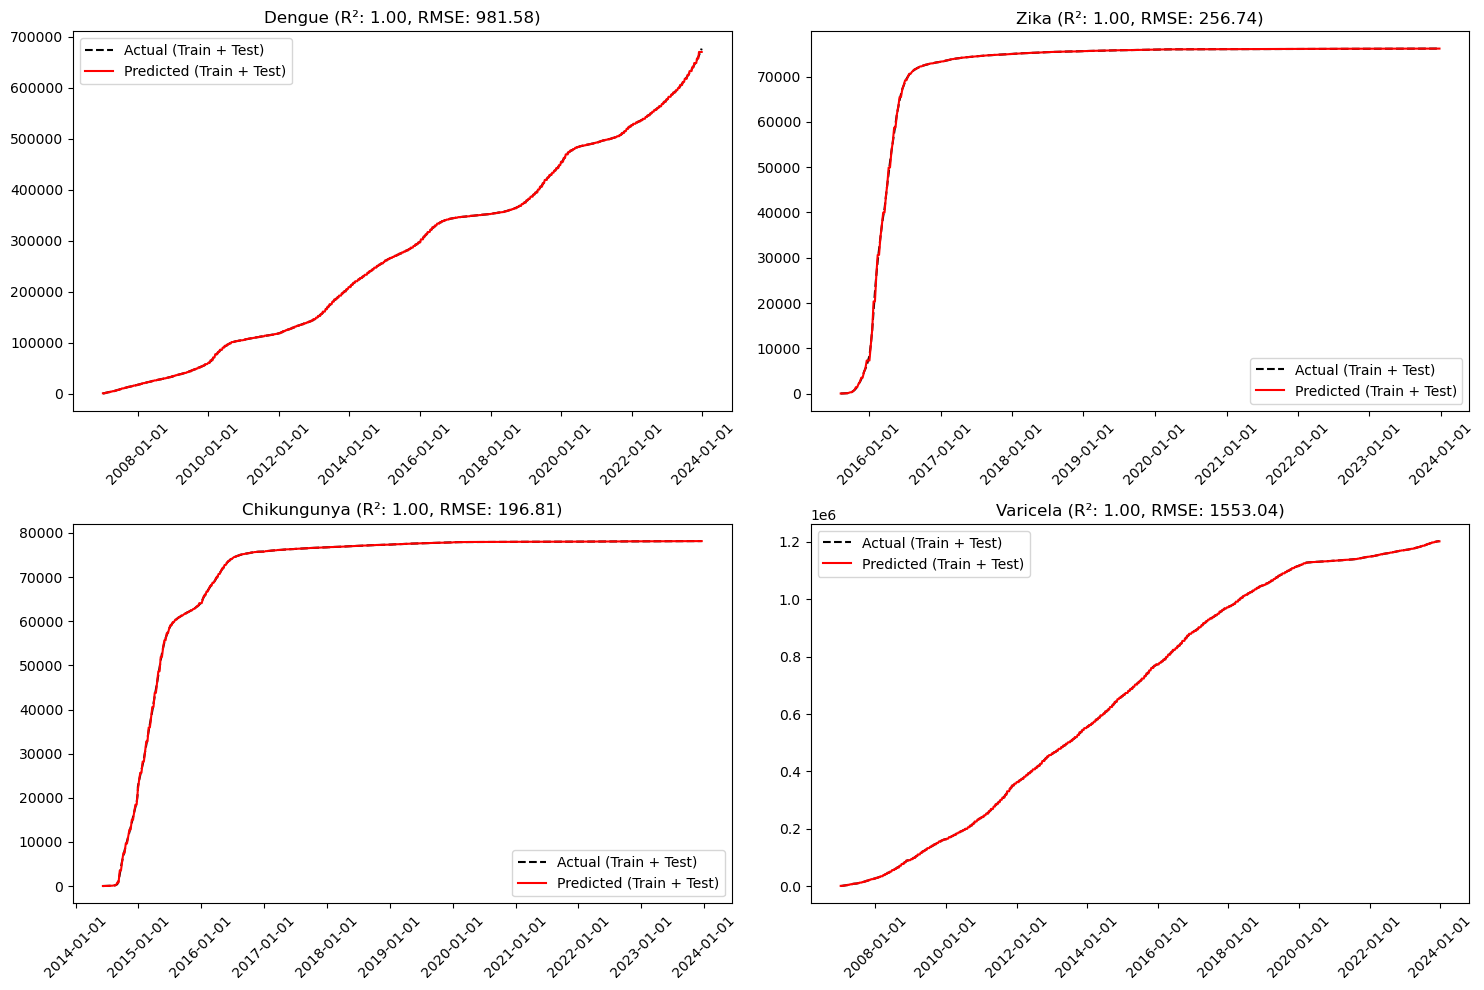

In [74]:
# Dictionary to store evaluation metrics
metrics = {}

# Define dataset dictionary
datasets = {
    "Dengue": df_dengue,
    "Zika": df_zika,
    "Chikungunya": df_chic,
    "Varicela": df_varicela
}

# Set up a 2-row x 2-column plot grid
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

# Loop through each dataset
for i, (name, df) in enumerate(datasets.items()):
    # Ensure DATE column is in datetime format
    df['DATE'] = pd.to_datetime(df['DATE'])

    # Ensure data is sorted by date
    df = df.sort_values(by='DATE')

    # Convert date to numeric (days since the first date)
    df['date_numeric'] = (df['DATE'] - df['DATE'].min()).dt.days

    # Compute cumulative cases
    df['cases'] = df['Casos'].cumsum()

    # Create a lag feature (cases with lag 1)
    df['cases_lag1'] = df['cases'].shift(1)

    # Drop NaN values created by the lag
    df = df.dropna()

    # Define target and features (including date_numeric)
    X = df[['date_numeric', 'cases_lag1']]
    y = df['cases']

    # Initialize and train XGBoost model on full data
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
    model.fit(X, y)

    # Predict on the full dataset
    y_pred = model.predict(X)

    # Compute performance metrics
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)

    # Store metrics in dictionary
    metrics[name] = {'R2': r2, 'RMSE': rmse}

    # Plot actual vs predicted values
    axes[i].plot(df['DATE'], y, label='Actual (Train + Test)', color='black', linestyle='dashed')
    axes[i].plot(df['DATE'], y_pred, label='Predicted (Train + Test)', color='red')
    axes[i].set_title(f"{name} (R²: {r2:.2f}, RMSE: {rmse:.2f})")
    axes[i].legend()

    # Improve date formatting
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    axes[i].xaxis.set_major_locator(mdates.AutoDateLocator())
    axes[i].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()


In [75]:
metrics_df = pd.DataFrame(metrics).T
metrics_df

,R2,RMSE
Dengue,0.999973,981.581345
Zika,0.999822,256.735911
Chikungunya,0.999900,196.807935
Varicela,0.999986,1553.043705


## Date + lag1: Train test split

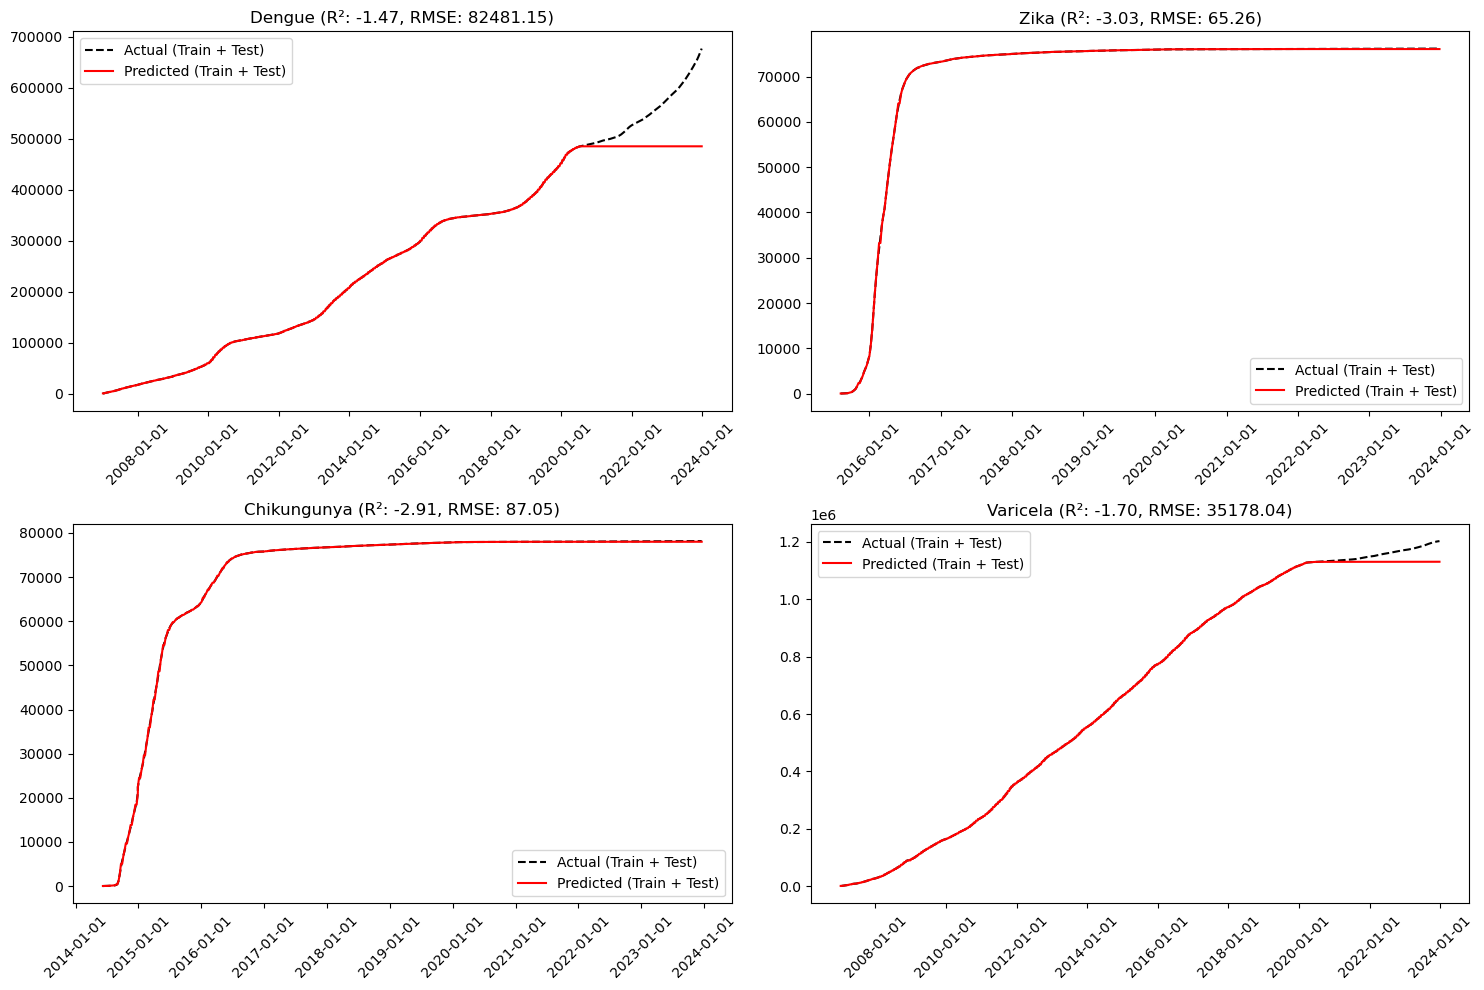

In [72]:
# Dictionary to store evaluation metrics
metrics = {}

# Define dataset dictionary
datasets = {
    "Dengue": df_dengue,
    "Zika": df_zika,
    "Chikungunya": df_chic,
    "Varicela": df_varicela
}

# Set up a 2-row x 2-column plot grid
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

# Loop through each dataset
for i, (name, df) in enumerate(datasets.items()):

     # Ensure DATE column is in datetime format
    df['DATE'] = pd.to_datetime(df['DATE'])

    # Ensure data is sorted by date
    df = df.sort_values(by='DATE')

    # Convert date to numeric (days since the first date)
    df['date_numeric'] = (df['DATE'] - df['DATE'].min()).dt.days

    # Compute cumulative cases
    df['cases'] = df['Casos'].cumsum()

    # Create a lag feature (cases with lag 1)
    df['cases_lag1'] = df['cases'].shift(1)

    # Drop NaN values created by the lag
    df = df.dropna()

    # Define target and features (including date_numeric)
    X = df[['date_numeric', 'cases_lag1']]
    y = df['cases']

    # Train-test split (80%-20%)
    split_idx = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # Initialize and train XGBoost model
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Predict on the full dataset (Train + Test)
    y_pred_full = model.predict(X)

    # Extract test predictions for evaluation
    y_pred_test = y_pred_full[split_idx:]

    # Compute performance metrics (ONLY on test set)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2 = r2_score(y_test, y_pred_test)

    # Store metrics in dictionary
    metrics[name] = {'R2': r2, 'RMSE': rmse}

    # Plot actual vs predicted values for full dataset
    axes[i].plot(df['DATE'], y, label='Actual (Train + Test)', color='black', linestyle='dashed')
    axes[i].plot(df['DATE'], y_pred_full, label='Predicted (Train + Test)', color='red')
    axes[i].set_title(f"{name} (R²: {r2:.2f}, RMSE: {rmse:.2f})")
    axes[i].legend()

    # Improve date formatting
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    axes[i].xaxis.set_major_locator(mdates.AutoDateLocator())
    axes[i].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()


In [73]:
metrics_df = pd.DataFrame(metrics).T
metrics_df

,R2,RMSE
Dengue,-1.473853,82481.153047
Zika,-3.026713,65.261246
Chikungunya,-2.913429,87.052777
Varicela,-1.695978,35178.040423
